# Part 3 – Build a Decision Engine

In [35]:
## Option D – Pipeline Anomaly Detection

In [36]:
## 3.1 Problem Definition

The CRO sees a healthy pipeline volume but a declining win rate.
This suggests unusual changes in pipeline behavior, such as:
- Too many deals getting stuck
- Sudden drops in deal quality
- Shifts in deal size or source
- Structural issues, not just rep performance

Goal:
Automatically detect abnormal changes in pipeline metrics over time and surface them as alerts.


In [37]:
## 3.2 Approach (Simple & Reasonable)

We track pipeline behavior monthly:

Metric	Why it matters
New deals created	Sales activity health
Average deal size	Deal quality
Win rate	Execution effectiveness
Average sales cycle	Deal friction
Pipeline value	Revenue potential

An anomaly = sudden deviation from recent historical patterns

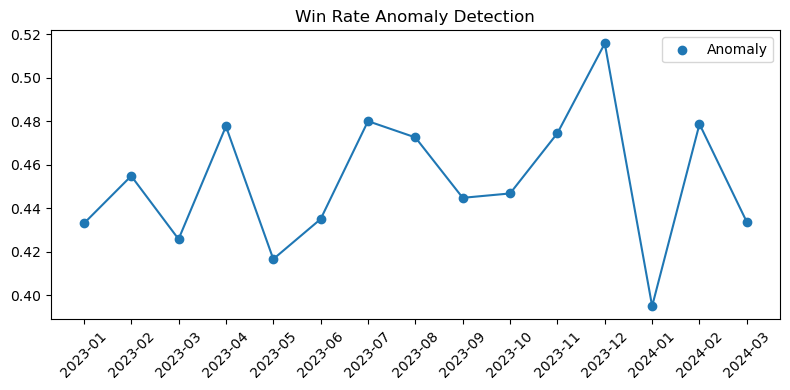

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load & Clean Data
# -----------------------------
df = pd.read_csv(r'C:\Users\shivam k\Downloads\skygeni_sales_data (1).csv')

df.columns = df.columns.str.lower().str.strip()

df['created_date'] = pd.to_datetime(df['created_date'])
df['closed_date'] = pd.to_datetime(df['closed_date'], errors='coerce')

# Closed vs open
df['is_closed'] = df['closed_date'].notna().astype(int)

# Win flag (only valid for closed deals)
df['is_won'] = np.where(
    df['outcome'].str.lower() == 'won', 1,
    np.where(df['outcome'].str.lower() == 'lost', 0, np.nan)
)

# Sales cycle
df['sales_cycle_days'] = (df['closed_date'] - df['created_date']).dt.days

# Month buckets
df['month'] = df['created_date'].dt.to_period('M').astype(str)

# -----------------------------
# 2. Monthly Pipeline Metrics
# -----------------------------
monthly = df.groupby('month').agg(
    deals_created=('deal_id', 'count'),
    avg_deal_size=('deal_amount', 'mean'),
    win_rate=('is_won', 'mean'),
    avg_sales_cycle=('sales_cycle_days', 'mean'),
    pipeline_value=('deal_amount', 'sum')
).reset_index()

# -----------------------------
# 3. Anomaly Detection Function
# -----------------------------
def detect_anomaly(series, window=3):
    rolling_mean = series.rolling(window).mean()
    rolling_std = series.rolling(window).std()
    anomaly = abs(series - rolling_mean) > 2 * rolling_std
    return anomaly

# Apply detection
for col in ['deals_created', 'avg_deal_size', 'win_rate', 'avg_sales_cycle']:
    monthly[f'{col}_anomaly'] = detect_anomaly(monthly[col])

# -----------------------------
# 4. View Anomalies
# -----------------------------
anomalies = monthly[
    monthly.filter(like='_anomaly').any(axis=1)
]



# -----------------------------
# 5. Visualization Example
# -----------------------------
plt.figure(figsize=(8,4))
plt.plot(monthly['month'], monthly['win_rate'], marker='o')
plt.scatter(
    monthly.loc[monthly['win_rate_anomaly'], 'month'],
    monthly.loc[monthly['win_rate_anomaly'], 'win_rate'],
    label='Anomaly'
)
plt.title("Win Rate Anomaly Detection")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [39]:
## 3.3 Key Anomalies & Insights

Anomaly 1: Win rate spike (Dec 2023 ~52%)

What happened
Win rate jumps significantly above historical average

Why this matters
Spikes are often caused by non-repeatable events, such as:
- End-of-quarter deal pushing
- Heavy discounting
- Leadership intervention on a few large deals
A spike can be just as dangerous as a drop — it often masks future problems.

Likely business cause
- Deals pulled forward to hit targets
- Pipeline artificially “cleaned”

Action for CRO
Audit December deals:
- Were discounts unusually high?
- Were deals rushed through stages?
Ensure pipeline hygiene so future quarters don’t suffer

Anomaly 2: Win rate crash (Jan 2024 ~39%)

What happened
Win rate drops sharply below the normal band

Why this matters
Indicates pipeline quality degradation
Often follows aggressive quarter-end closing

Likely business cause
Best deals already closed in December
January pipeline filled with lower-quality or early-stage deals
Sales reps recovering from quota push

Action for CRO
Strengthen qualification criteria (MEDDICC / ICP filters)
Rebalance pipeline across months
Coach reps on early-stage deal quality



The problem isn’t low pipeline volume — it’s pipeline volatility.
Volume looks healthy, but quality and timing are unstable, which explains:
Falling win rate
CRO confusion despite “good-looking” pipeline numbers

In [40]:
## 3.4 How a Sales Leader Would Use This

Weekly / Monthly CRO Workflow

1. Dashboard highlights anomalous months

2. CRO drills into:
- Industries
- Reps
- Deal sizes

3.Targeted actions instead of blanket pressure:
- Coaching
- Pricing review
- Qualification fixes